# WSI - Ćwiczenie 2

*Autor: Maksymilian Nowak*

### Cel ćwiczenia

Celem ćwiczenia jest zaimplementowanie algorytmu ewolucyjnego:
- z selekcją turniejową ($k=2$)
- krzyżowaniem jednopunktowym
- mutacją gaussowską
- sukcesją generacyjną

Należy również wykorzystać ten algorytm do znalezienia minimum sumy funkcji $f_1+f_2$, gdzie: 
$$f_1(x_1,y_1)=(x_1^2+y_1-11)^2+(x_1+y_1^2-7)^2$$
$$f_2(x_2,y_2)=2*x_2^2+1.05*x_2^4+\frac{x_2^6}{6}+x_2y_2+y_2^2$$
dla dziedziny $D=[-5,5]\times[-5,5]$, oraz zbadać wpływ dystrybucji populacji początkowej, prawdopodobieństwa mutacji oraz prawdopodobieństwa krzyżowania na współrzędne znalezionych minimów funkcji $f_1$.

## Implementacja algorytmu ewolucyjnego

Do implementacji algorytmu przyjąłem następujące założenia:
- Funkcja celu ma następującą postać: $g(x_1, x_2, y_1, y_2)=f_1(x_1,y_1)+f_2(x_2,y_2)$
- Osobnik jest postaci $(x_1,x_2,y_1,y_2)$
- Kryterium stopu w algorytmie będzie maksymalna liczba pokoleń

Na początku zdefiniuję badane funkcje oraz funkcję celu, będącą ich sumą:

In [1]:
def f1(x, y):
    return (x**2 + y - 11)**2 + (x + y**2 - 7)**2

def f2(x, y):
    return 2*x**2 + 1.05*x**4 + (1/6)*x**6 + x*y + y**2

def g(x1, x2, y1, y2):
    return f1(x1, y1) + f2(x2, y2)

Pozostałymi hiperparametrami algorytmu będą:
- prawdopodobieństwo mutacji
- siła mutacji 
- prawdopodobieństwo krzyżowania

Przed zaimplementowaniem algorytmu wyznaczę funkcję oceny - wartością zwracaną przez tę funkcję będzie wynik funkcji celu (im mniejszy, tym lepsza ocena). Dodatkowo kara za wyjście poza dziedzinę funkcji przez osobnika to dodanie 1000 do wyniku działania funkcji oceny.

In [2]:
def rate(genes):
    penalty = 0
    domain_conditions = [-5 <= gene <= 5 for gene in genes]
    if not all(domain_conditions):
        penalty += 1000
    return g(genes[0], genes[1], genes[2], genes[3]) + penalty

Następnie zdefiniuję funkcje odpowiedzialne za reprodukcję, krzyżowanie i mutację, z których będzie się składał algorytm ewoulucyjny.

In [3]:
import random
import numpy as np

# Reprodukcja - selekcja turniejowa (turnieje dwuosobnikowe)
def reproduction(population, rating):
    results = []
    for i, individual in enumerate(population):
        opponents = population.copy()
        opponents.pop(i)
        opponent = random.choice(opponents)
        if rating(individual) < rating(opponent):
            results.append(individual)
        else:
            results.append(opponent)
    return results

# Krzyżowanie jednopunktowe - każda para rodziców produkuje dwójkę dzieci
def crossing(population, crossover_prob):
    results = []
    parents_list = population.copy()
    for i in range(0, len(population) - 1, 2):
        crossover_value = random.uniform(0, 1)
        parent1, parent2 = random.sample(parents_list, 2)
        parents_list.remove(parent1)
        parents_list.remove(parent2)
        if crossover_value < crossover_prob:
            crossing_point = random.randint(1, len(parent1))
            child1, child2 = [
                parent1[:crossing_point] + parent2[crossing_point:],
                parent2[:crossing_point] + parent1[crossing_point:]
            ]
            results.append(child1)
            results.append(child2)
        else:
            results.append(parent1)
            results.append(parent2)
    # Jeśli populacja jest nieparzysta, przenieś rodzica bez pary do wyników
    if len(population) % 2 == 1:
        results.append(parents_list[0])
    return results

# Mutacja gaussowska
def mutation(population, mutation_strength, mutation_prob):
    results = []
    for individual in population:
        mutation_value = random.uniform(0, 1)
        if mutation_value < mutation_prob:
            results.append((individual + mutation_strength * np.random.normal(0, 1, len(individual))).tolist())
        else:
            results.append(individual)
    return results


#### Zaimplementowany algorytm ewolucyjny

In [4]:
def g_minimum(population, rating, crossover_prob, mutation_strength, mutation_prob, max_generations):
    generation = 0
    ratings = [rating(individual) for individual in population]
    best_value = min(ratings)
    best_value_index = ratings.index(best_value)
    best_individual = population[best_value_index]
    while generation < max_generations:
        reproducted = reproduction(population, rating) # Reprodukcja
        crossed = crossing(reproducted, crossover_prob) # Krzyżowanie
        mutated = mutation(crossed, mutation_strength, mutation_prob) # Mutowanie
        # Ocena nowego pokolenia
        new_ratings = [rating(individual) for individual in mutated]
        new_best_value = min(new_ratings)
        new_best_value_index = new_ratings.index(new_best_value)
        new_best_individual = mutated[new_best_value_index]
        if new_best_value < best_value:
            best_value = new_best_value
            best_individual = new_best_individual
        # Sukcesja generacyjna
        population = mutated
        ratings = new_ratings
        generation += 1
    return [best_individual, best_value]

### Szukanie rozwiązania

Przy szukaniu rozwiązania będę wykorzystywał zawsze wykorzystywał populację w postaci 20 osobników o identycznych wartościach genów rosnących od -5 do 5.
Poszukiwania rozpocznę od wartości prawdopodobieństw równych 0,5 oraz siły mutacji równej 0,1.
Maksymalna liczba pokoleń początkowo wyniesie 100.

Ze względu na obecność czynnika losowego przy działaniu algorytmu, dla każdego zestawu hiperparametrów algorytm będzie uruchamiany 250 razy, a następnie zwrócone zostaną:
- uśrednione wartości poszczególnych genów osobników w populacji
- średnia otrzymana wartość funkcji celu
- najlepsza (minimalna) otrzymana wartość tej funkcji
- najgorsza otrzymana wartość tej funkcji
- odchylenie standardowe otrzymanych wyników

In [5]:
x1 = np.linspace(-5, 5, 20)
x2 = np.linspace(-5, 5, 20)
y1 = np.linspace(-5, 5, 20)
y2 = np.linspace(-5, 5, 20)
individuals = list(map(list, zip(x1, x2, y1, y2)))
print(f"Populacja początkowa: {individuals}")

def find_min(population, rate, crossover_prob, mutation_strength, mutation_prob, max_generations, no_of_experiments):
    individual_results = []
    value_results = [] 
    for i in range(no_of_experiments):
        result = g_minimum(population, rate, crossover_prob, mutation_strength, mutation_prob, max_generations)
        individual_results.append(result[0])
        value_results.append(result[1])
    gene_values = list(zip(*individual_results))
    average_individual = [
        sum(gene_values[0]) / len(gene_values[0]),
        sum(gene_values[1]) / len(gene_values[1]),
        sum(gene_values[2]) / len(gene_values[2]),
        sum(gene_values[3]) / len(gene_values[3]),
    ]
    average_value = sum(value_results) / len(value_results)
    print("Uśrednione wartości genów osobników w postaci [x1, x2, y1, y2]:", average_individual)
    print("Średnia wartość funkcji celu:", average_value)
    print("Najlepsza znaleziona wartość", min(value_results))
    print("Najgorsza znaleziona wartość", max(value_results))
    print("Odchylenie standardowe wartości osobników:", np.std(value_results))

Populacja początkowa: [[-5.0, -5.0, -5.0, -5.0], [-4.473684210526316, -4.473684210526316, -4.473684210526316, -4.473684210526316], [-3.947368421052632, -3.947368421052632, -3.947368421052632, -3.947368421052632], [-3.4210526315789473, -3.4210526315789473, -3.4210526315789473, -3.4210526315789473], [-2.8947368421052633, -2.8947368421052633, -2.8947368421052633, -2.8947368421052633], [-2.368421052631579, -2.368421052631579, -2.368421052631579, -2.368421052631579], [-1.8421052631578947, -1.8421052631578947, -1.8421052631578947, -1.8421052631578947], [-1.3157894736842106, -1.3157894736842106, -1.3157894736842106, -1.3157894736842106], [-0.7894736842105265, -0.7894736842105265, -0.7894736842105265, -0.7894736842105265], [-0.2631578947368425, -0.2631578947368425, -0.2631578947368425, -0.2631578947368425], [0.2631578947368416, 0.2631578947368416, 0.2631578947368416, 0.2631578947368416], [0.7894736842105257, 0.7894736842105257, 0.7894736842105257, 0.7894736842105257], [1.3157894736842106, 1.31

In [6]:
find_min(individuals, rate, 0.5, 0.1, 0.5, 100, 250)

Uśrednione wartości genów osobników w postaci [x1, x2, y1, y2]: [2.854183287004348, -0.0008348665633953353, 1.9244910120144119, 0.004136791540685841]
Średnia wartość funkcji celu: 0.01205773232440195
Najlepsza znaleziona wartość 0.0005550269408349268
Najgorsza znaleziona wartość 0.15839350776349598
Odchylenie standardowe wartości osobników: 0.013902131681042576


Otrzymane rozwiązanie znajduje się blisko prawdziwego minimum, którego wartość wynosi 0 (minimalną wartość funkcji celu sprawdziłem za pomocą programu WolframAlpha).
Spróbuję teraz zmienić wartość prawdopodobieństwa krzyżowania z 0,5 na 0,8 i powtórzyć eksperyment:

In [7]:
find_min(individuals, rate, 0.8, 0.1, 0.5, 100, 250)

Uśrednione wartości genów osobników w postaci [x1, x2, y1, y2]: [2.5132495966354744, -5.051408240719828e-05, 1.9450277024223175, 0.0003395929869655468]
Średnia wartość funkcji celu: 0.00860311676871766
Najlepsza znaleziona wartość 0.00038799906969149605
Najgorsza znaleziona wartość 0.07406936183792959
Odchylenie standardowe wartości osobników: 0.007944535828862419


Po zmianie margines błędu algorytmu znacząco zmalał. Teraz zbadam, czy zwiększenie liczby pokoleń wpłynie na otrzymywane wyniki - ustawię wartość tego hiperparametru na 200:

In [8]:
find_min(individuals, rate, 0.8, 0.1, 0.5, 200, 250)

Uśrednione wartości genów osobników w postaci [x1, x2, y1, y2]: [2.7195390267042443, -0.00029459878259310374, 1.9194064932677737, 0.0019775193110726165]
Średnia wartość funkcji celu: 0.0035791919198651006
Najlepsza znaleziona wartość 0.00036201756233851426
Najgorsza znaleziona wartość 0.010704484852046253
Odchylenie standardowe wartości osobników: 0.002152553953998698


Zgodnie z moimi oczekiwaniami, większa liczba pokoleń wpłynęła pozytywnie na otrzymywany wynik. Spróbuję poprawić średnie otrzymywane wyniki, zmniejszając siłę mutacji na 0.3

In [9]:
find_min(individuals, rate, 0.8, 0.1, 0.3, 200, 250)

Uśrednione wartości genów osobników w postaci [x1, x2, y1, y2]: [2.5711377162413225, -0.0008220230342739814, 1.9528565315800461, 0.0008819257651802153]
Średnia wartość funkcji celu: 0.0009990328415809982
Najlepsza znaleziona wartość 9.349324845597836e-06
Najgorsza znaleziona wartość 0.008556543652103506
Odchylenie standardowe wartości osobników: 0.000996770176453456



##### Tabela z otrzymanymi rezultatami

| Prawdopodobieństwo krzyżowania | Siła mutacji | Prawdopodobieństwo mutacji | Liczba pokoleń | Średni wynik | Najlepszy wynik | Najgorszy wynik | Odchylenie standardowe |
| --- | --- | --- | --- | --- | --- | --- | --- |
| 0.5 | 0.1 | 0.5 | 100 | 0.011 | 0.001 | 0.032 | 0.007 |
| 0.8 | 0.1 | 0.5 | 100 | 0.007 | 0.001 | 0.019 | 0.004 |
| 0.8 | 0.1 | 0.5 | 200 | 0.004 | 0.001 | 0.009 | 0.002 |

### Wpływ poszczególnych hiperparametrów na znajdowane minimum funkcji $f_1$

Eksperymenty będę przeprowadzał w następujący sposób:

1. Populacja początkowa będzie równomiernie rozłożona po dziedzinie funkcji (z wyjątkiem badania wpływu dystrybucji populacji początkowej)
2. Eksperyment będzie uruchamiany 1000 razy, najlepsze osobniki z każdego uruchomienia będą zapisywane do specjalnej listy
3. Następnie generowany będzie wykres funkcji $f_1$ z zaznaczonymi genami $x_1$, $y_1$ każdego osobnika z wcześniej zdefiniowanej listy 
4. Dodatkowo przy badaniu wpływu wartości prawdopodobieństwa mutacji oraz krzyżowania generowany będzie wykres porównujący precyzję otrzymywanych wyników (im wartość funkcji $f_1$ bliższa zeru, tym lepiej)

Algorytm będzie uruchamiany z następującymi hiperparametrami (chyba że jeden z nich będzie badany):
- prawdopodobieństwo krzyżowania: 0,8
- siła mutacji: 0,5
- prawdopodobieństwo mutacji: 0,3
- liczba pokoleń: 100

In [10]:
import matplotlib.pyplot as plt

def plot_results(population, rate, crossover_prob, mutation_strength, mutation_prob, max_generations, no_of_experiments):
    best_genes = []
    for _ in range(no_of_experiments):
        experiment = g_minimum(population, rate, crossover_prob, mutation_strength, mutation_prob, max_generations)
        best_genes.append([experiment[0][0], experiment[0][2]]) # dodaj tylko wartości genów x1 i y1

    # Wykres
    x1 = np.linspace(-5, 5, 20)
    y1 = np.linspace(-5, 5, 20)
    X1, Y1 = np.meshgrid(x1, y1)
    z = f1(X1, Y1)
    plt.contourf(X1, Y1, z, 50)
    plt.colorbar()
    plt.scatter(*zip(*best_genes), color="red", s=1)
    plt.xlabel("x1")
    plt.ylabel("y1")
    plt.show()


#### Dystrybucja populacji początkowej

Przed rozpoczęciem eksperymentów zdefiniuję dwie populacje osobników:
- z jednorodną dystrybucją po całym obszarze dziedziny funkcji z odstępami wynoszącymi 0.5
- z dystrybucją zgodną z rozkładem normalnym wokół $x_1=-0.3, y_1=-0.9$ dla $f_1$ oraz dowolnie przyjętą dla $x_2, y_2$

In [11]:
# Jednorodna dystrybucja
x = np.linspace(-5, 5, 10)
y = np.linspace(-5, 5, 10)
X, Y = np.meshgrid(x, y)
even_individuals = list(map(list, zip(X.flatten(), X.flatten(), Y.flatten(), Y.flatten())))

# Rozkład normalny
distributed_individuals = []
for _ in range(100):
    distributed_individuals.append([
        np.random.normal(-0.3, 1),
        np.random.normal(0, 1),
        np.random.normal(-0.9, 1),
        np.random.normal(0, 1)
    ])

##### Dystrybucja jednorodna po obszarze

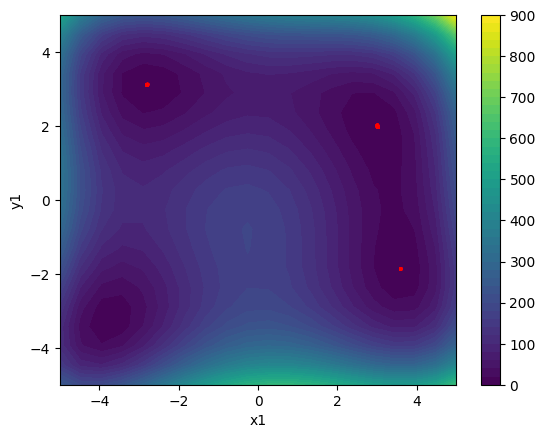

In [12]:
plot_results(even_individuals, rate, 0.8, 0.5, 0.3, 100, 1000)

Z powyższego wykresu wynika, że punkty zbiegały do każdego z czterech minimów funkcji $f_1$. Najpopularniejszym minimum "wybieranym" przez osobników był punkt znajdujący się w okolicach $x_1=3, y_1=2$.

##### Dystrybucja zgodna z rozkładem normalnym

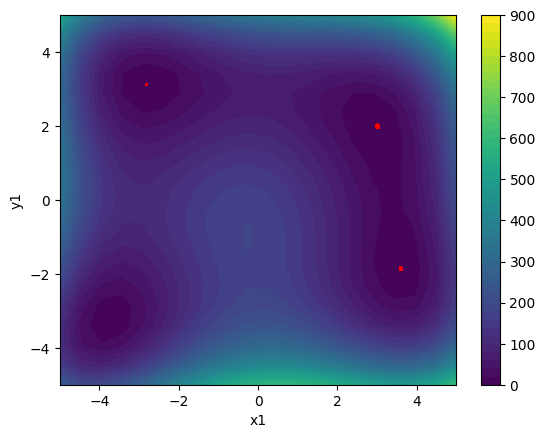

In [13]:
plot_results(distributed_individuals, rate, 0.8, 0.5, 0.3, 100, 1000)

W przypadku dystrybucji populacji zgodnie z rozkładem minimalnym wokół $x_1=-0.3, y_1=-0.9$ algorytm zbiegał tylko do dwóch z czterech minimów funkcji $f_1$ - cechą wspólną tych minimów była wartość $y_1>0$.

#### Prawdopodobieństwo mutacji

Będę badał wartości od 0.01 do 0.5 w odstępach wynoszących 0.05.

##### Wartość 0.01

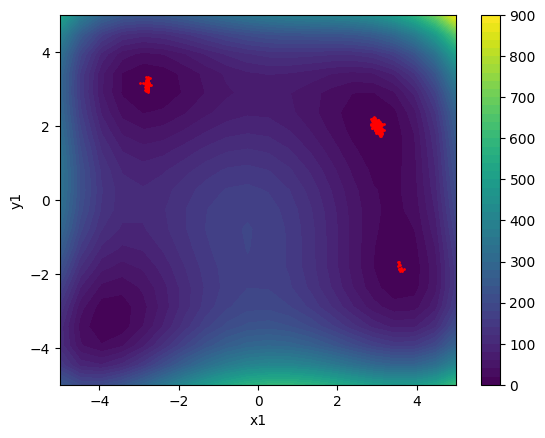

In [14]:
plot_results(even_individuals, rate, 0.8, 0.5, 0.01, 100, 1000)

##### Wartość 0.05

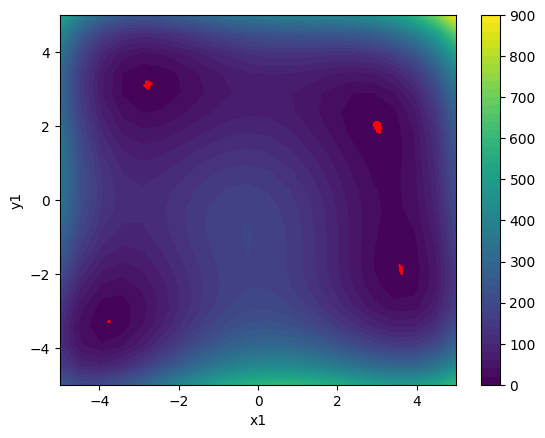

In [15]:
plot_results(even_individuals, rate, 0.8, 0.5, 0.05, 100, 1000)

##### Wartość 0.1

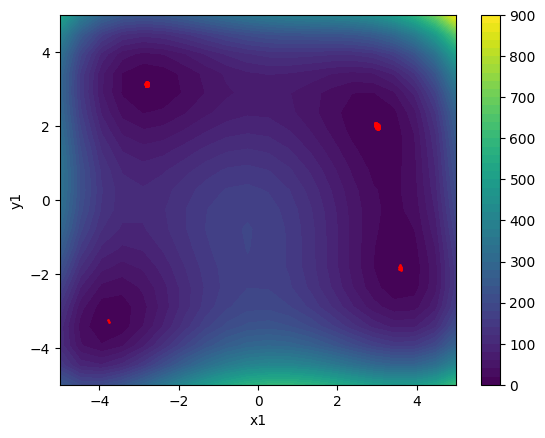

In [16]:
plot_results(even_individuals, rate, 0.8, 0.5, 0.1, 100, 1000)

##### Wartość 0.15

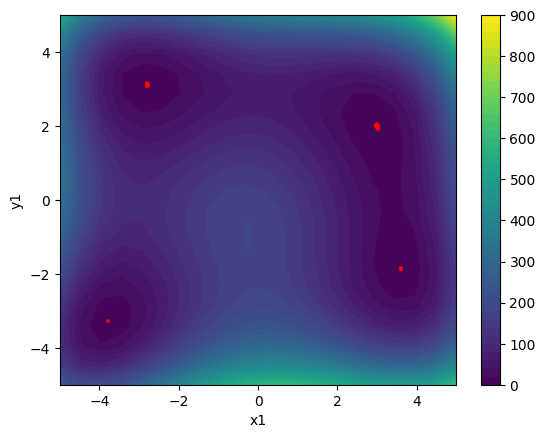

In [17]:
plot_results(even_individuals, rate, 0.8, 0.5, 0.15, 100, 1000)

##### Wartość 0.2

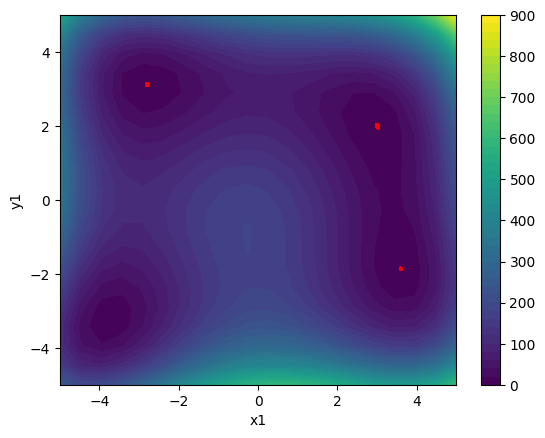

In [18]:
plot_results(even_individuals, rate, 0.8, 0.5, 0.2, 100, 1000)

##### Wartość 0.25

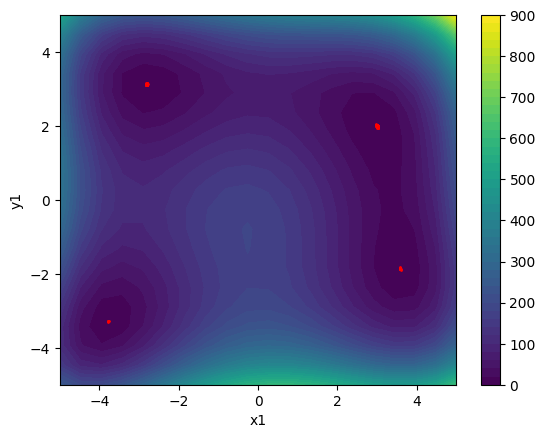

In [19]:
plot_results(even_individuals, rate, 0.8, 0.5, 0.25, 100, 1000)

##### Wartość 0.3

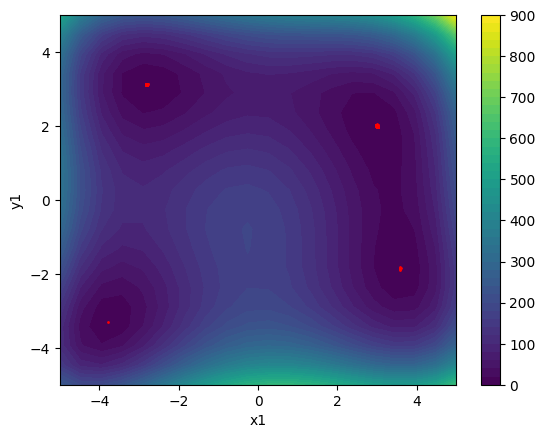

In [20]:
plot_results(even_individuals, rate, 0.8, 0.5, 0.3, 100, 1000)

##### Wartość 0.35

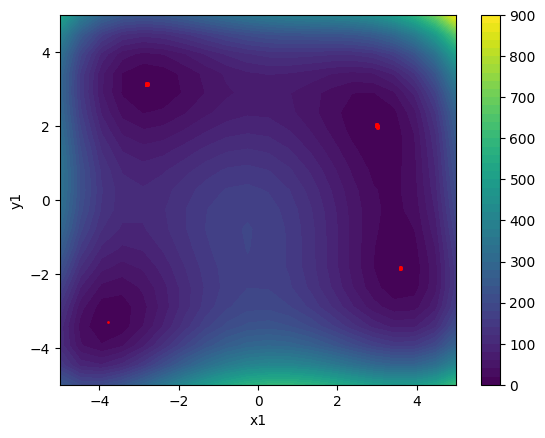

In [21]:
plot_results(even_individuals, rate, 0.8, 0.5, 0.35, 100, 1000)

##### Wartość 0.4

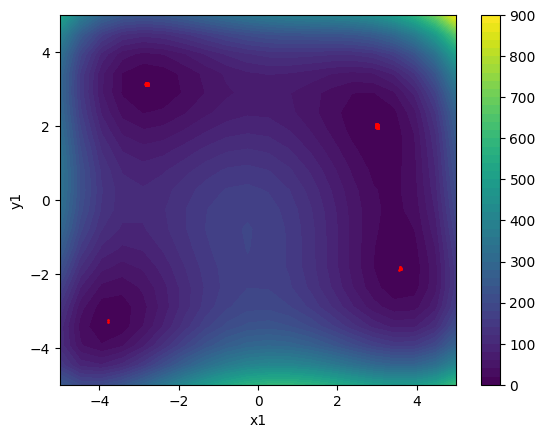

In [22]:
plot_results(even_individuals, rate, 0.8, 0.5, 0.4, 100, 1000)

##### Wartość 0.45

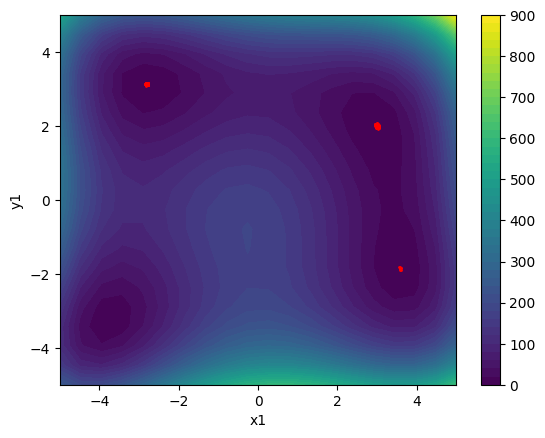

In [23]:
plot_results(even_individuals, rate, 0.8, 0.5, 0.45, 100, 1000)

##### Wartość 0.5

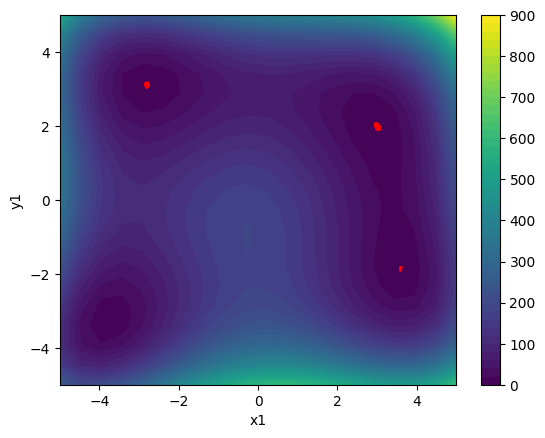

In [24]:
plot_results(even_individuals, rate, 0.8, 0.5, 0.5, 100, 1000)

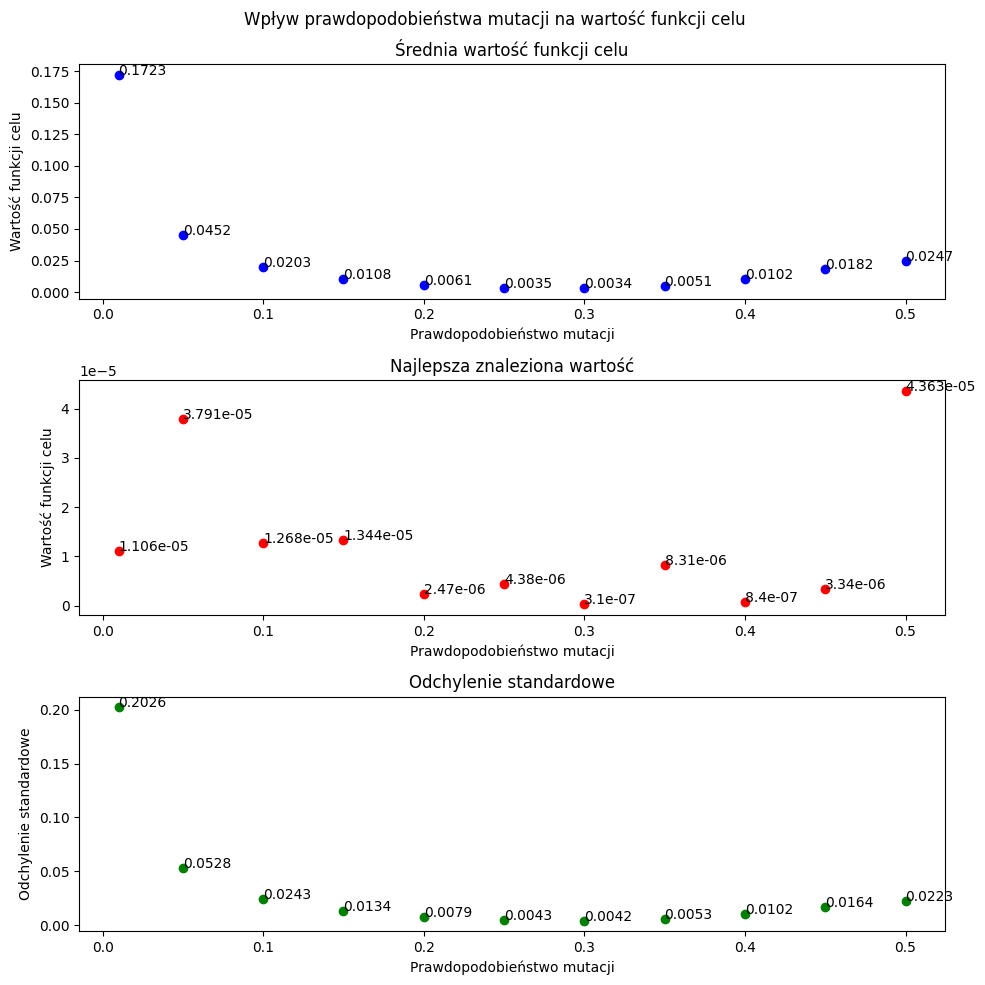

In [25]:
def mutation_experiments():
    # Ze względu na niedokładność operacji dodawania liczb zmiennoprzecinkowych
    # wartości prawdopodobieństw są zaokrąglane do 2 miejsc po przecinku
    steps = [0.01] + [round(x, 2) for x in np.arange(0.05, 0.51, 0.05)]
    current = 0.01 
    plot_values = []
    plot_best = []
    plot_deviation = []
    while current < 0.51:
        experiment_values = []
        for _ in range(1000):
            result = g_minimum(even_individuals, rate, 0.8, 0.5, round(current, 2), 100)
            experiment_values.append(f1(result[0][0], result[0][2]))
        plot_values.append(sum(experiment_values) / len(experiment_values))
        plot_best.append(min(experiment_values))
        plot_deviation.append(np.std(experiment_values))
        if current == 0.01:
            current = 0.05
        else:
            current += 0.05

    fig, axs = plt.subplots(3, figsize=(10, 10))
    fig.suptitle("Wpływ prawdopodobieństwa mutacji na wartość funkcji celu")
    axs[0].scatter(steps, plot_values, color="blue")
    axs[0].set_title("Średnia wartość funkcji celu")
    axs[0].set_ylabel("Wartość funkcji celu")
    axs[0].set_xlabel("Prawdopodobieństwo mutacji")
    for i, txt in enumerate(plot_values):
        axs[0].annotate(round(txt, 4), (steps[i], plot_values[i]))
    axs[1].scatter(steps, plot_best, color="red")
    axs[1].set_title("Najlepsza znaleziona wartość")
    axs[1].set_ylabel("Wartość funkcji celu")
    axs[1].set_xlabel("Prawdopodobieństwo mutacji")
    for i, txt in enumerate(plot_best):
        axs[1].annotate(round(txt, 8), (steps[i], plot_best[i]))
    axs[2].scatter(steps, plot_deviation, color="green")
    axs[2].set_title("Odchylenie standardowe")
    axs[2].set_ylabel("Odchylenie standardowe")
    axs[2].set_xlabel("Prawdopodobieństwo mutacji")
    for i, txt in enumerate(plot_deviation):
        axs[2].annotate(round(txt, 4), (steps[i], plot_deviation[i]))
    plt.tight_layout()
    plt.show()

mutation_experiments()    

#### Prawdopodobieństwo krzyżowania

Będę badał wartości od 0.8 do 0.95 w odstępach wynoszących 0.01.

##### Wartość 0.8

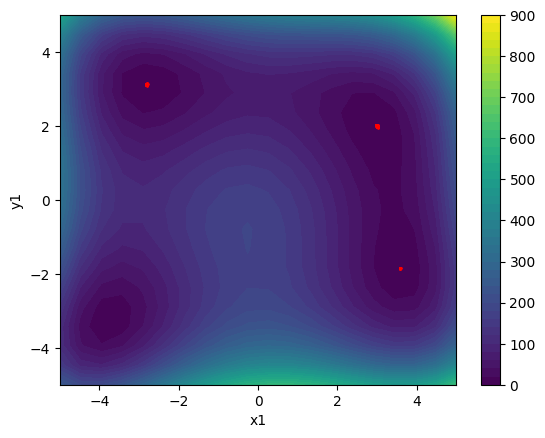

In [26]:
plot_results(even_individuals, rate, 0.8, 0.5, 0.3, 100, 1000)

##### Wartość 0.81

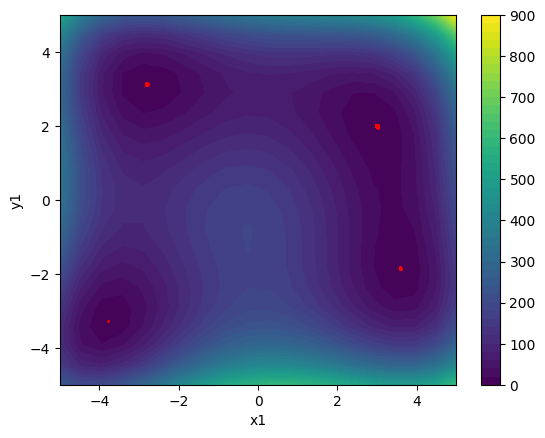

In [27]:
plot_results(even_individuals, rate, 0.81, 0.5, 0.3, 100, 1000)

##### Wartość 0.82

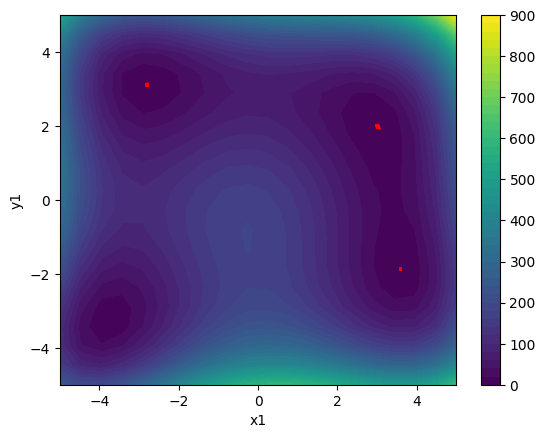

In [28]:
plot_results(even_individuals, rate, 0.82, 0.5, 0.3, 100, 1000)

##### Wartość 0.83

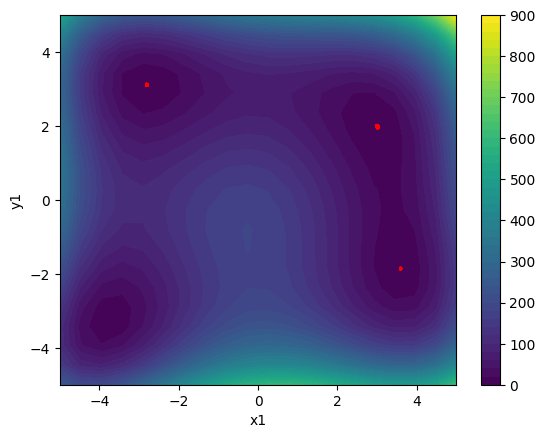

In [29]:
plot_results(even_individuals, rate, 0.83, 0.5, 0.3, 100, 1000)

##### Wartość 0.84

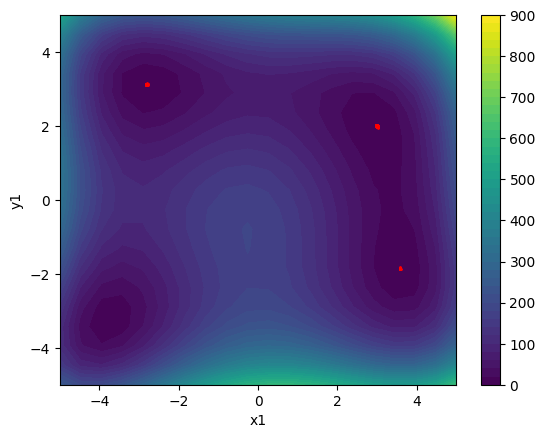

In [30]:
plot_results(even_individuals, rate, 0.84, 0.5, 0.3, 100, 1000)

##### Wartość 0.85

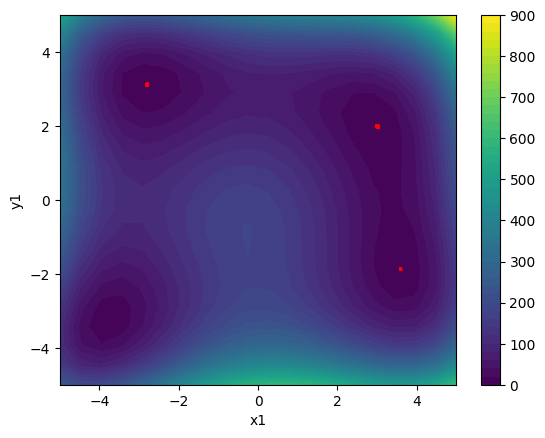

In [31]:
plot_results(even_individuals, rate, 0.85, 0.5, 0.3, 100, 1000)

##### Wartość 0.86

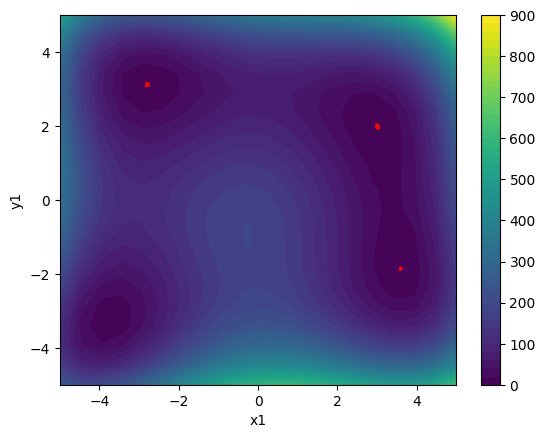

In [32]:
plot_results(even_individuals, rate, 0.86, 0.5, 0.3, 100, 1000)

##### Wartość 0.87

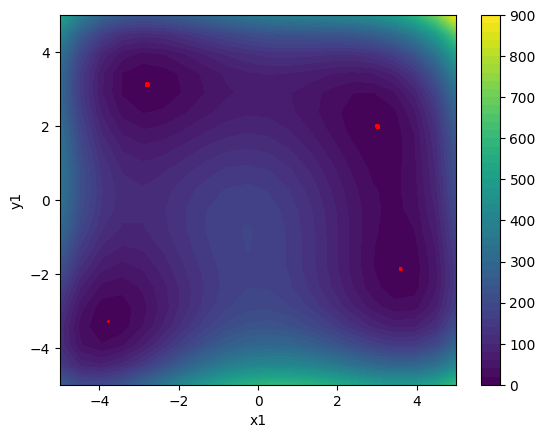

In [33]:
plot_results(even_individuals, rate, 0.87, 0.5, 0.3, 100, 1000)

##### Wartość 0.88

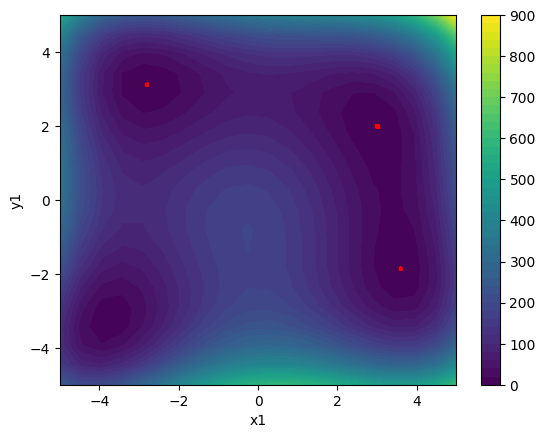

In [34]:
plot_results(even_individuals, rate, 0.88, 0.5, 0.3, 100, 1000)

##### Wartość 0.89

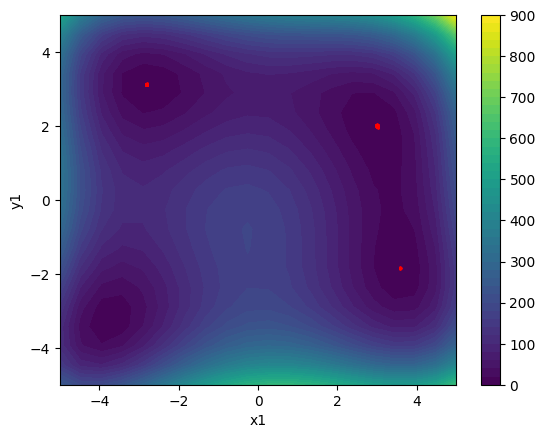

In [35]:
plot_results(even_individuals, rate, 0.89, 0.5, 0.3, 100, 1000)

##### Wartość 0.9

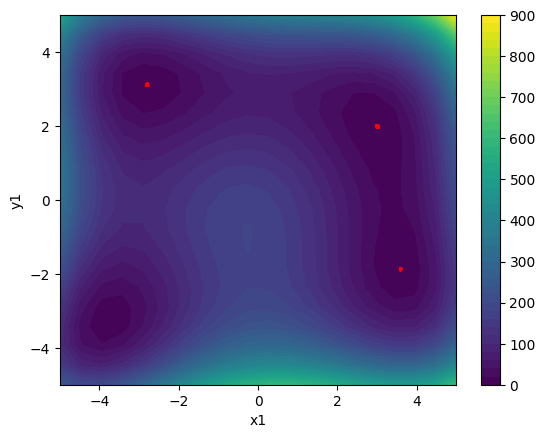

In [36]:
plot_results(even_individuals, rate, 0.9, 0.5, 0.3, 100, 1000)

##### Wartość 0.91

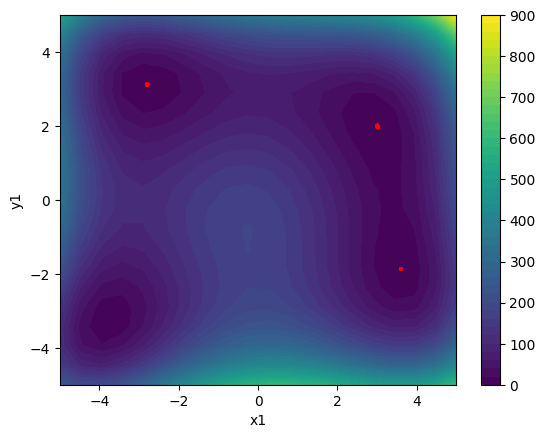

In [37]:
plot_results(even_individuals, rate, 0.91, 0.5, 0.3, 100, 1000)

##### Wartość 0.92

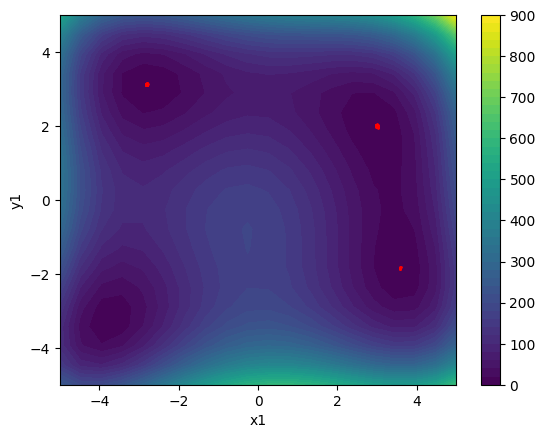

In [38]:
plot_results(even_individuals, rate, 0.92, 0.5, 0.3, 100, 1000)

##### Wartość 0.93

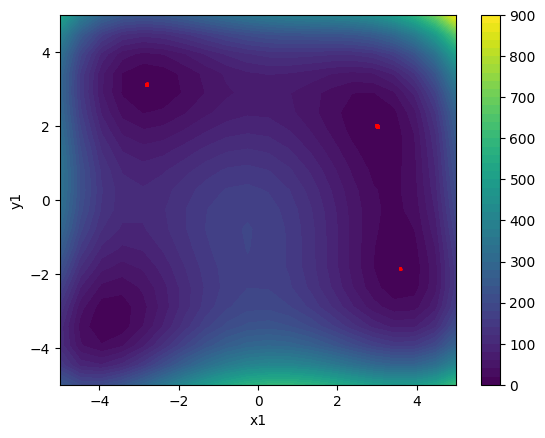

In [39]:
plot_results(even_individuals, rate, 0.93, 0.5, 0.3, 100, 1000)

##### Wartość 0.94

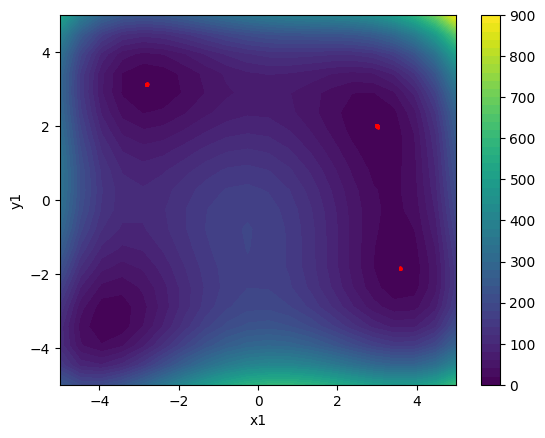

In [40]:
plot_results(even_individuals, rate, 0.94, 0.5, 0.3, 100, 1000)

##### Wartość 0.95

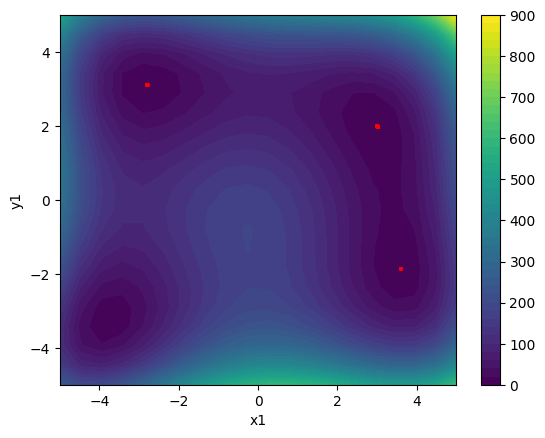

In [41]:
plot_results(even_individuals, rate, 0.95, 0.5, 0.3, 100, 1000)

##### Porównanie otrzymywanych wartości funkcji $f_1$

Aby przeprowadzić ten eksperyment, zdefiniuję funkcję, która uruchomi algorytm ewolucyjny dla zbadanych wyżej wartości, zapisze otrzymaną średnią minimalną wartość funkcji $f_1$ dla każdej z nich, a następnie narysuje wykres porównujący je.

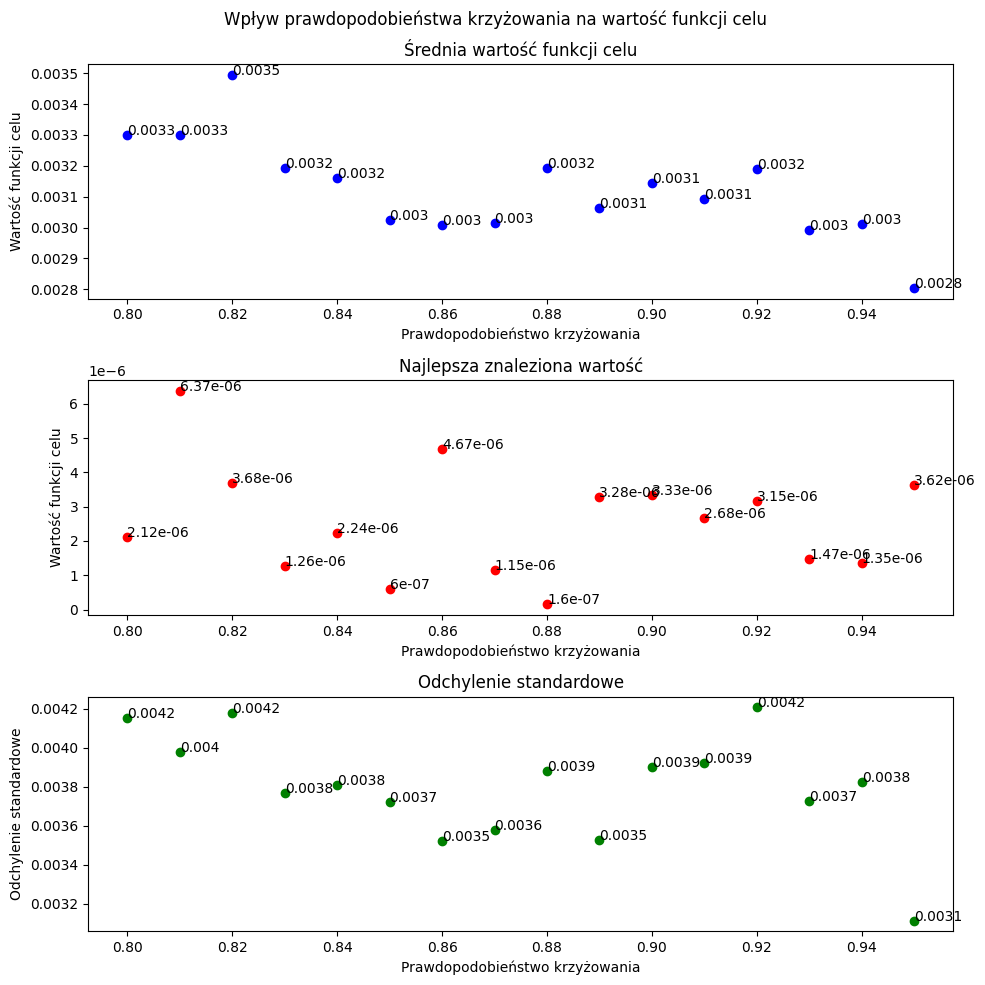

In [42]:
def crossover_experiments():
    # Ze względu na niedokładność operacji dodawania liczb zmiennoprzecinkowych
    # wartości prawdopodobieństw są zaokrąglane do 2 miejsc po przecinku
    steps = [round(x, 2) for x in np.arange(0.8, 0.951, 0.01)]
    current = 0.8 
    plot_values = []
    plot_best = []
    plot_deviation = []
    while current < 0.951:
        experiment_values = []
        for _ in range(1000):
            result = g_minimum(even_individuals, rate, round(current, 2), 0.5, 0.3, 100)
            experiment_values.append(f1(result[0][0], result[0][2]))
        plot_values.append(sum(experiment_values) / len(experiment_values))
        plot_best.append(min(experiment_values))
        plot_deviation.append(np.std(experiment_values))
        current += 0.01

    fig, axs = plt.subplots(3, figsize=(10, 10))
    fig.suptitle("Wpływ prawdopodobieństwa krzyżowania na wartość funkcji celu")
    axs[0].scatter(steps, plot_values, color="blue")
    axs[0].set_title("Średnia wartość funkcji celu")
    axs[0].set_ylabel("Wartość funkcji celu")
    axs[0].set_xlabel("Prawdopodobieństwo krzyżowania")
    for i, txt in enumerate(plot_values):
        axs[0].annotate(round(txt, 4), (steps[i], plot_values[i]))
    axs[1].scatter(steps, plot_best, color="red")
    axs[1].set_title("Najlepsza znaleziona wartość")
    axs[1].set_ylabel("Wartość funkcji celu")
    axs[1].set_xlabel("Prawdopodobieństwo krzyżowania")
    for i, txt in enumerate(plot_best):
        axs[1].annotate(round(txt, 8), (steps[i], plot_best[i]))
    axs[2].scatter(steps, plot_deviation, color="green")
    axs[2].set_title("Odchylenie standardowe")
    axs[2].set_ylabel("Odchylenie standardowe")
    axs[2].set_xlabel("Prawdopodobieństwo krzyżowania")
    for i, txt in enumerate(plot_deviation):
        axs[2].annotate(round(txt, 4), (steps[i], plot_deviation[i]))
    plt.tight_layout()
    plt.show()

crossover_experiments()

##### Wnioski

Zmiana hiperparametru odpowiedzialnego za prawdopodobieństwo krzyżowania nie wpłynęła znacząco na współrzędne znajdowanych minimów funkcji $f_1$. Pondato dodatkowy eksperyment w postaci badania otrzymanej wartości minimum funkcji nie wykazał żadnych trendów związanych ze zmianą hiperparametru.